Основная идея алгоритма LK заключена в трех предположениях.

1. *Постоянство яркости*. Пиксель объекта на изображении не изменяется внешне (по возможности) при перемещении от кадра к кадру. Для серого изображения (LK так же можно применять и для цветного изображения) это предположение означает, что яркость пикселя не изменяется при слежении от кадра к кадру.

2. *Временное постоянство или "малые перемещения"*. Изменение движущейся поверхности патча изображения во времени происходит очень медленно. На практике это означает, что приращение времени достаточно велико относительно масштаба движения в изображении, то есть объект мало перемещаем от кадра к кадру.

3. *Пространственная когерентность*. Соседние точки на сцене, принадлежащие одной поверхности, имеют аналогичные движения и проектируются к соседним точкам на плоскости изображения.

![](img/assumptions.jpg)

https://dspace.spbu.ru/bitstream/11701/5002/1/diplom_gr__633_Smirnov_K__V.pdf

https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%9B%D1%83%D0%BA%D0%B0%D1%81%D0%B0_%E2%80%94_%D0%9A%D0%B0%D0%BD%D0%B0%D0%B4%D0%B5

https://github.com/ant76/TranslateBookLearningOpenCV/blob/master/Chapter10/OpticalFlow.md

In [6]:
import numpy as np
import cv2, os, imageio, shutil
import matplotlib.pyplot as plt

In [7]:
def get_optical_flow_gif(filename, window_size, max_corners, min_quality, min_distance):
    # Считываем гиф и узнаем количество кадров
    gif = cv2.VideoCapture(filename)
    count_frames = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))

    # Создаем папки для промежуточных результатов
    if not os.path.exists('gif'):
        os.makedirs('gif')
    if not os.path.exists('result'):
        os.makedirs('result')
    if not os.path.exists('separate_result'):
        os.makedirs('separate_result')

    # Сохраняем кадры нашей gif'ки в папку gif
    for i in range(count_frames):
        _, frame = gif.read()
        cv2.imwrite(f'gif/image{i}.png', frame)

    # Делим нашу gif'ку на попарные кадры для построения потока
    for i in range(count_frames - 1):
        img1 = cv2.imread(f"gif/image{i}.png")
        img2 = cv2.imread(f"gif/image{i + 1}.png")

        # Будем считать, что рассматриваются черно-белые изображения, в
        # этом случае цвет точки изображения определяется одним числом, которое
        # будем далее называть яркостью или же интенсивностью I
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

        # Считаем поток, получаем две матрицы U и V
        U, V = optical_flow(img1, img2, window_size, max_corners, min_quality, min_distance)

        # Сохраняем результаты
        img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
        createFramesSeparatePlot(img1, img2, U, V, f'separate_result/image_{i}.png')
        createFlowOnFrames(img2, U, V, f'result/image_{i}.png')

    # Создаем массив результативных кадров для превращения в гифку
    result_images = []
    separate_result_images = []

    for i in range(count_frames - 1):
        filename = f'result/image_{i}.png'
        result_images.append(imageio.imread(filename))
        filename = f'separate_result/image_{i}.png'
        separate_result_images.append(imageio.imread(filename))
        
    # Сохраняем результаты в гиф
    imageio.mimsave('result.gif', result_images)    
    imageio.mimsave('separate_result.gif', separate_result_images)

    # Чистим за собой
    def clean_folder(folder):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print('Failed to delete %s. Reason: %s' % (file_path, e))
                    
    clean_folder('gif')
    clean_folder('result')
    clean_folder('separate_result')               
    os.rmdir('gif')
    os.rmdir('result')
    os.rmdir('separate_result')

In [8]:
def optical_flow(old_frame, new_frame, window_size, max_corners, min_quality, min_distance):

    # Функция, которая ищет max_corners углов в old_frame по алгоритму Ши-Томази
    # Изображение обязательно должно быть в градациях серого
    # min_quality - минимальное качество угла, которое мы хотим получить
    # min_distance - минимальное евклидово расстояние между углами
    # Пример работы: http://espressocode.top/python-detect-corner-of-an-image-using-opencv/
    feature_list = cv2.goodFeaturesToTrack(old_frame, max_corners, min_quality, min_distance)
    w = window_size // 2

    # Приводим к диапазону [0, 1] для удобства понимания интенсивности пикселей
    old_frame = old_frame / 255
    new_frame = new_frame / 255

    # Матрицы-фильтры для x, y и t для дальнейшего применения filter2D()
    filterX = np.array([[-1, 1], [-1, 1]])
    filterY = np.array([[-1, -1], [1, 1]])
    filterT = np.array([[1, 1], [1, 1]])
    
    # Фильтруем кадр так, чтобы изменить значение интенсивности пикселей
    # Это поможет выявить или удалить определенные характеристики изображения
    # Пример работы: https://www.askpython.com/python-modules/opencv-filter2d
    filtered_x = cv2.filter2D(old_frame, -1, filterX)
    filtered_y = cv2.filter2D(old_frame, -1, filterY)
    filtered_t = cv2.filter2D(new_frame, -1, filterT) - cv2.filter2D(old_frame, -1, filterT)

    u = np.zeros(old_frame.shape)
    v = np.zeros(old_frame.shape)

    for feature in feature_list:
            # Получаем пиксельные координаты угла
            j, i = feature.ravel()		
            i, j = int(i), int(j)

            # Подсчет частных производных в окошке w
            I_x = filtered_x[i-w:i+w+1, j-w:j+w+1].flatten()
            I_y = filtered_y[i-w:i+w+1, j-w:j+w+1].flatten()
            I_t = filtered_t[i-w:i+w+1, j-w:j+w+1].flatten()
            
            # Математическая часть алгоритма An = b или же A(u, v) = b (wikipedia)
            b = np.reshape(I_t, (I_t.shape[0],1))
            A = np.vstack((I_x, I_y)).T

            # https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html
            n = np.matmul(np.linalg.pinv(A), b)

            # Полученные вектора смещения
            u[i, j] = n[0][0]
            v[i, j] = n[1][0]
 
    return (u, v)

In [9]:
def createFlowOnFrames(frame, U, V, output_file):
    '''
    Для каждого пикселя построить вектор смещения (при наличии) и нарисовать этот вектор на изображении
    '''
    color = (255, 0, 0)
    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            u, v = U[i][j], V[i][j]
            if u and v:
                frame = cv2.arrowedLine(frame, 
                                        (j, i), 
                                        (int(round(j + v)), int(round(i + u))),
                                        color,
                                        thickness=1)
    cv2.imwrite(output_file, frame)

def createFramesSeparatePlot(old_frame, new_frame, U, V, output_file):
    move = np.ones_like(new_frame)
    move.fill(255.)             
    
    for i in range(new_frame.shape[0]):
        for j in range(new_frame.shape[1]):
            start_pixel = (j, i)
            end_pixel = (int(j + V[i][j]) , int(i + U[i][j]))

            if U[i][j] and V[i][j] and IsCoordsInFrame(end_pixel, old_frame.shape):     
                move = cv2.arrowedLine(move, start_pixel, end_pixel, (0, 0, 0), thickness=2)

    figure, axes = plt.subplots(1,3)
    axes[0].imshow(old_frame, cmap = "gray")
    axes[0].set_title("Frame i")
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)

    axes[1].imshow(new_frame, cmap = "gray")
    axes[1].set_title("Frame i + 1")
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)

    axes[2].imshow(move, cmap = "gray")
    axes[2].set_title("Move from i to i + 1")
    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)

    figure.tight_layout()
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.savefig(output_file, bbox_inches = "tight", dpi = 800)

def IsCoordsInFrame(cordinates, limits):
	x, y = cordinates
	limit_x, limit_y = limits
	return 0 <= x < limit_x and 0 <= y < limit_y

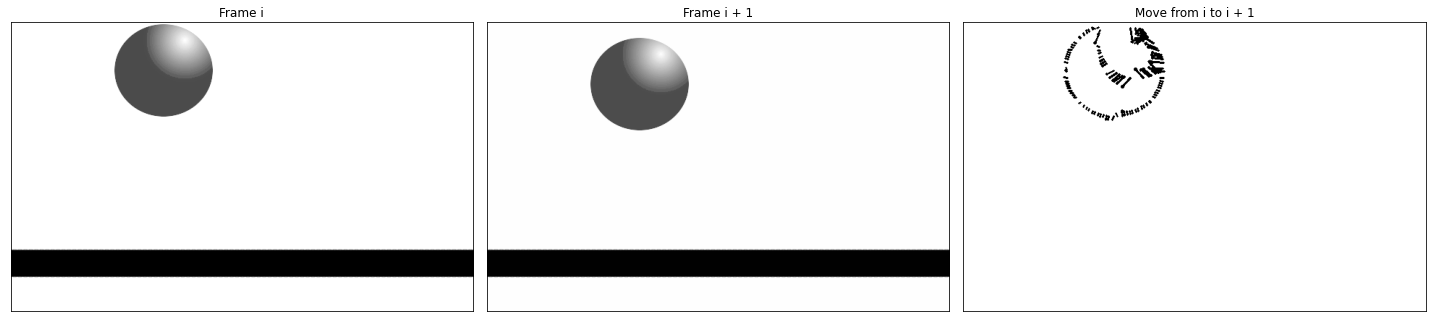

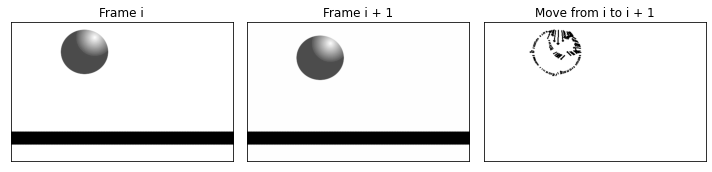

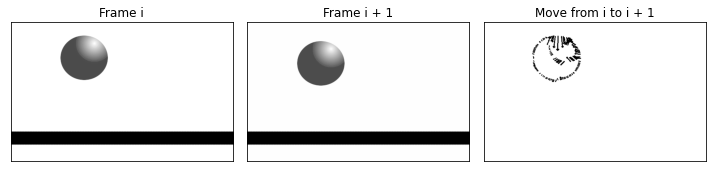

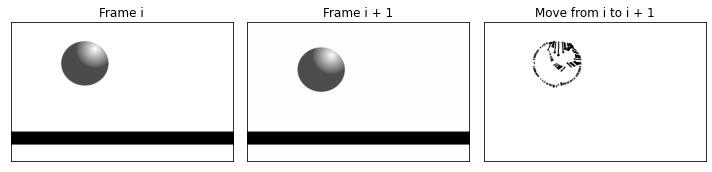

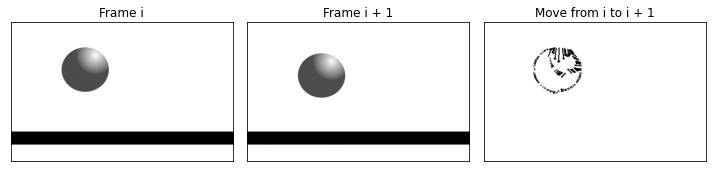

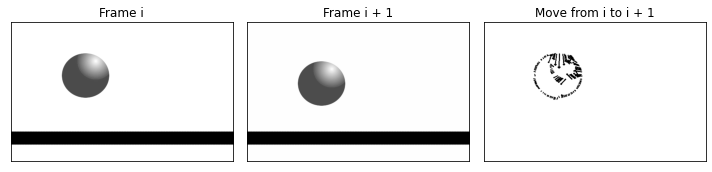

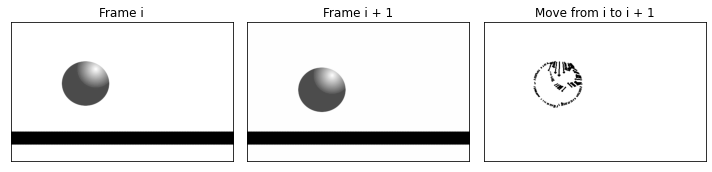

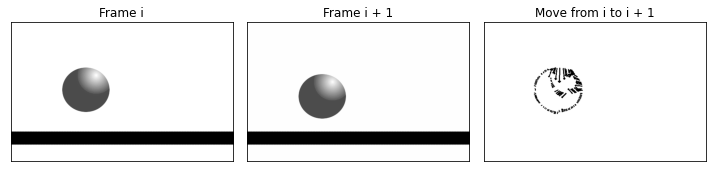

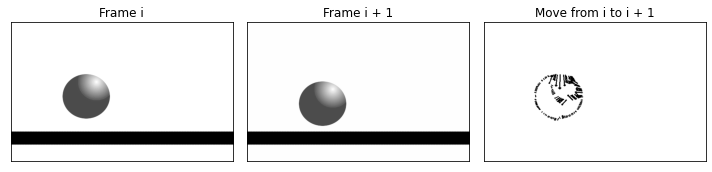

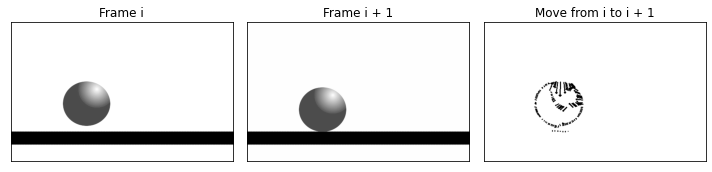

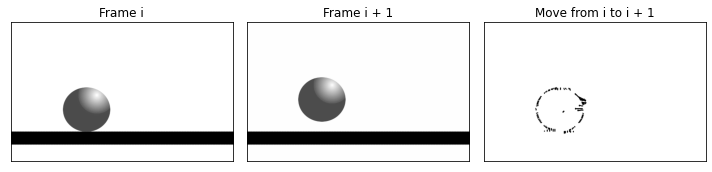

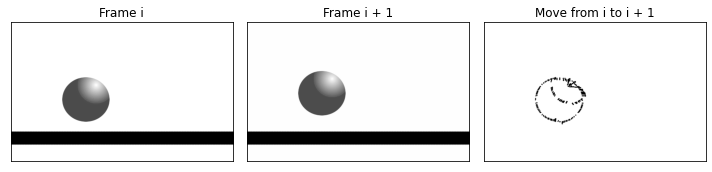

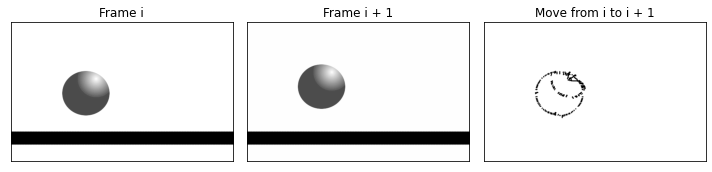

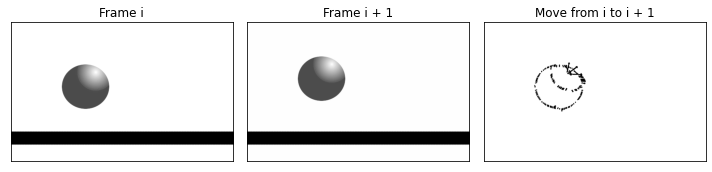

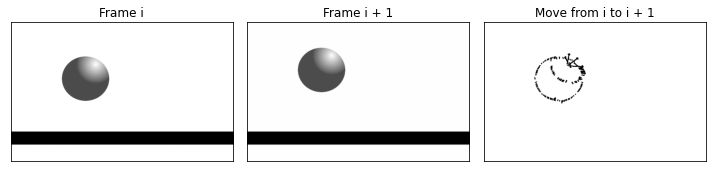

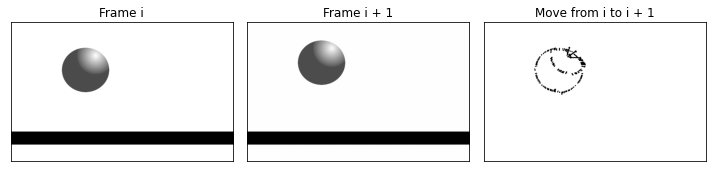

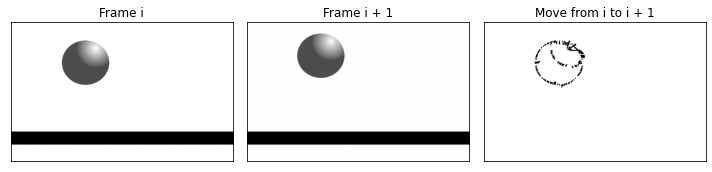

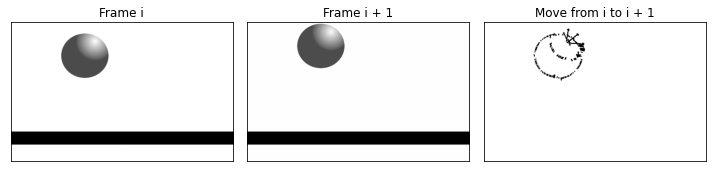

In [10]:
get_optical_flow_gif('redball2.gif', 
                     window_size=15, 
                     max_corners=400, 
                     min_quality=0.01, 
                     min_distance=3)